In [1]:
import os
import dotenv

dotenv.load_dotenv()
os.chdir(os.environ["PYTHONPATH"])

In [2]:
import torch

# load the embedding model

In [ ]:
from transformers import (
    T5EncoderModel,
    T5Tokenizer,
    pipeline
)

In [3]:
device = torch.device("cuda:0")

print(device, "is used")

model_name = "Rostlab/prot_t5_xl_uniref50"

tokenizer = T5Tokenizer.from_pretrained(model_name, do_lower_case=False)
model = T5EncoderModel.from_pretrained(model_name).to(device)

# if device == torch.device("cpu"):
    # model.to(torch.float32)

embeddings_pipeline = pipeline("feature-extraction", model=model, tokenizer=tokenizer)

cuda:0 is used


You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Device set to use cuda:0


In [13]:
def embed_sequences(row):
    row['sequence_embedding'] = embeddings_pipeline(row['sequence'])[0][0]
    return row

# calculate embeddings and perform cluster analysis

In [3]:
import numpy as np
import pandas as pd
from datasets import Dataset

## embeddings calculation

In [8]:
prot_df = pd.read_csv("data/similarity/proteins.csv")
prot_df

,hash,sequence,len,len_bin
0,f4700b879aef8c84b62418d2a47de698e9e331176c8579...,MSSSSPSSQSRLSVPGRTPHLPPLTIPHTVSAEGLATPNTPHALLP...,529,"(433.0, 689.0]"
1,14d37ac5624cf44e84d31c34be0c59931899daa3fdcd16...,PHRYRPGTVALREIRRYQKSTELLIRKLPFQRLVREIAQDFKTDLR...,756,"(689.0, 5890.0]"
2,39abc653d9fbeddc04309795feae21d6fb4b1c4d1c2d15...,MGKYTKTAILSVYDKTGLLDLAKGLVENNVRILASGGTANMVREAG...,591,"(433.0, 689.0]"
3,1e4cca78876ecb4b0683037381aa0b7c2ef252ab746871...,MLEICLKLVGCKSKKGLSSSSSCYLEEALQRPVASDFEPQGLSEAA...,1130,"(689.0, 5890.0]"
4,d09efb0ddd42cab0c93f2137c542a6da14eb19c5eec283...,MGETLGDSPVDPEHGAFADALPMSTSQEITMVDTEMPFWPTNFGIS...,505,"(433.0, 689.0]"
...,...,...,...,...
63189,9a122fc06407b99169e30f2e0f63dd0d076dd27a3f863b...,MTWRQAVLLSCFSAVVLLSMLREGTSVSVGTMQMAGEEASEDAKQK...,138,"(99.999, 278.0]"
63190,c422d561d3c69cf4fe601b522a664fe7934008e982df9e...,MAEPASVTVTFDDVALYFSEQEWEILEKWQKQMYKQEMKTNYETLD...,752,"(689.0, 5890.0]"
63191,231ee06744cadd3f373b33cdaf191a22f6e98e7fdee8ad...,MLVVQMPFSFPMAHFILFVFTVSTIFHVQQRLAKIQAMWELPVQIP...,343,"(278.0, 433.0]"
63192,74ab43e422350613e89be6f5fde367457228794e235520...,MANDTHTDDLDELLDSALDDFKDLNLTQRNGGVKKEEGDKKETESL...,245,"(99.999, 278.0]"


In [9]:
prot_df['len_bin'].value_counts()

len_bin
(99.999, 278.0]    15858
(433.0, 689.0]     15814
(689.0, 5890.0]    15768
(278.0, 433.0]     15754
Name: count, dtype: int64

In [ ]:
# go to the gpu land
prot_dataset = Dataset.from_pandas(prot_df)

In [14]:
embed_prot_dataset = prot_dataset.map(embed_sequences)

Map:   0%|          | 0/63194 [00:00<?, ? examples/s]

In [17]:
embed_prot_dataset.to_parquet("data/similarity/protein_embeddings.parquet.gzip")

Creating parquet from Arrow format:   0%|          | 0/64 [00:00<?, ?ba/s]

559890659

## estimate embeddings with cosine similarity

In [4]:
# back to the cpu land
embed_prot_df = pd.read_parquet("data/similarity/protein_embeddings.parquet.gzip")

In [5]:
total_samples = embed_prot_df.shape[0]
eval_emb_sample = embed_prot_df.sample(total_samples // 4)

In [6]:
eval_emb_sample_pairs = eval_emb_sample[['sequence_embedding']].merge(eval_emb_sample[['sequence_embedding']], how='cross')

In [7]:
from scipy.spatial import distance

emb_x = eval_emb_sample_pairs['sequence_embedding_x']
emb_y = eval_emb_sample_pairs['sequence_embedding_y']

cos_sim = distance.cosine(emb_x, emb_y)

TypeError: only length-1 arrays can be converted to Python scalars

In [ ]:
# back to gpu land
eval_emb_sample_pairs_dataset = Dataset.from_pandas(eval_emb_sample_pairs)

In [ ]:
def get_cosine_similarity(row):
    row['cosine_similarity'] = torch.nn.functional.cosine_similarity(
        row['sequence_embedding_x'],
        row['sequence_embedding_y'],
    )
    return row

eval_emb_sample_pairs_dataset = eval_emb_sample_pairs_dataset.map(get_cosine_similarity)

## clustering analysis

In [ ]:

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

import seaborn as sns
import matplotlib.pyplot as plt

`KMeans` is used as the main alogithm for clustering

`silhouette_score` is used as the measure of clustering efficiency. Scores above 0.7 are considered to have strong clustering power, 0.5 - normal, 0.25 - weak

`TSNE` and `PCA` are used for the dimensionality reduction for the sake of embeddings visualisation

In [ ]:
embeddings = embed_prot_df['sequence_embedding']

perform search for the optimal clusters number based on the `silhouette_score` metric

In [65]:
scores_grid = {}
for num_clusters in range(2, 11):
    kmeans = KMeans(n_clusters=num_clusters)
    kmeans.fit(embeddings)
    cluster_labels = kmeans.predict(embeddings)
    scores_grid[num_clusters] = silhouette_score(embeddings, cluster_labels, random_state=423)
scores_grid

{2: 0.9998408829025001,
 3: 0.9998439907190984,
 4: 0.999831553943906,
 5: 0.9998020112170526,
 6: 0.9998043778237019,
 7: 0.9998482047592602,
 8: 0.9998597099093728,
 9: 0.9999080857223525,
 10: 0.9999117584805928}

PCA visualization

In [ ]:
# todo: scaling
pca = PCA(n_components=2)
transformed_embeddings = pd.DataFrame(pca.fit_transform(embeddings), columns=['pca1', 'pca2'])

In [39]:
transformed_embeddings

,pca1,pca2
0,0.000125,-0.000373
1,0.000125,-0.000373
2,0.000125,-0.000373
3,0.000125,-0.000373
4,0.000125,-0.000373
...,...,...
63189,0.000125,-0.000373
63190,0.000125,-0.000373
63191,0.000125,-0.000373
63192,0.000125,-0.000373


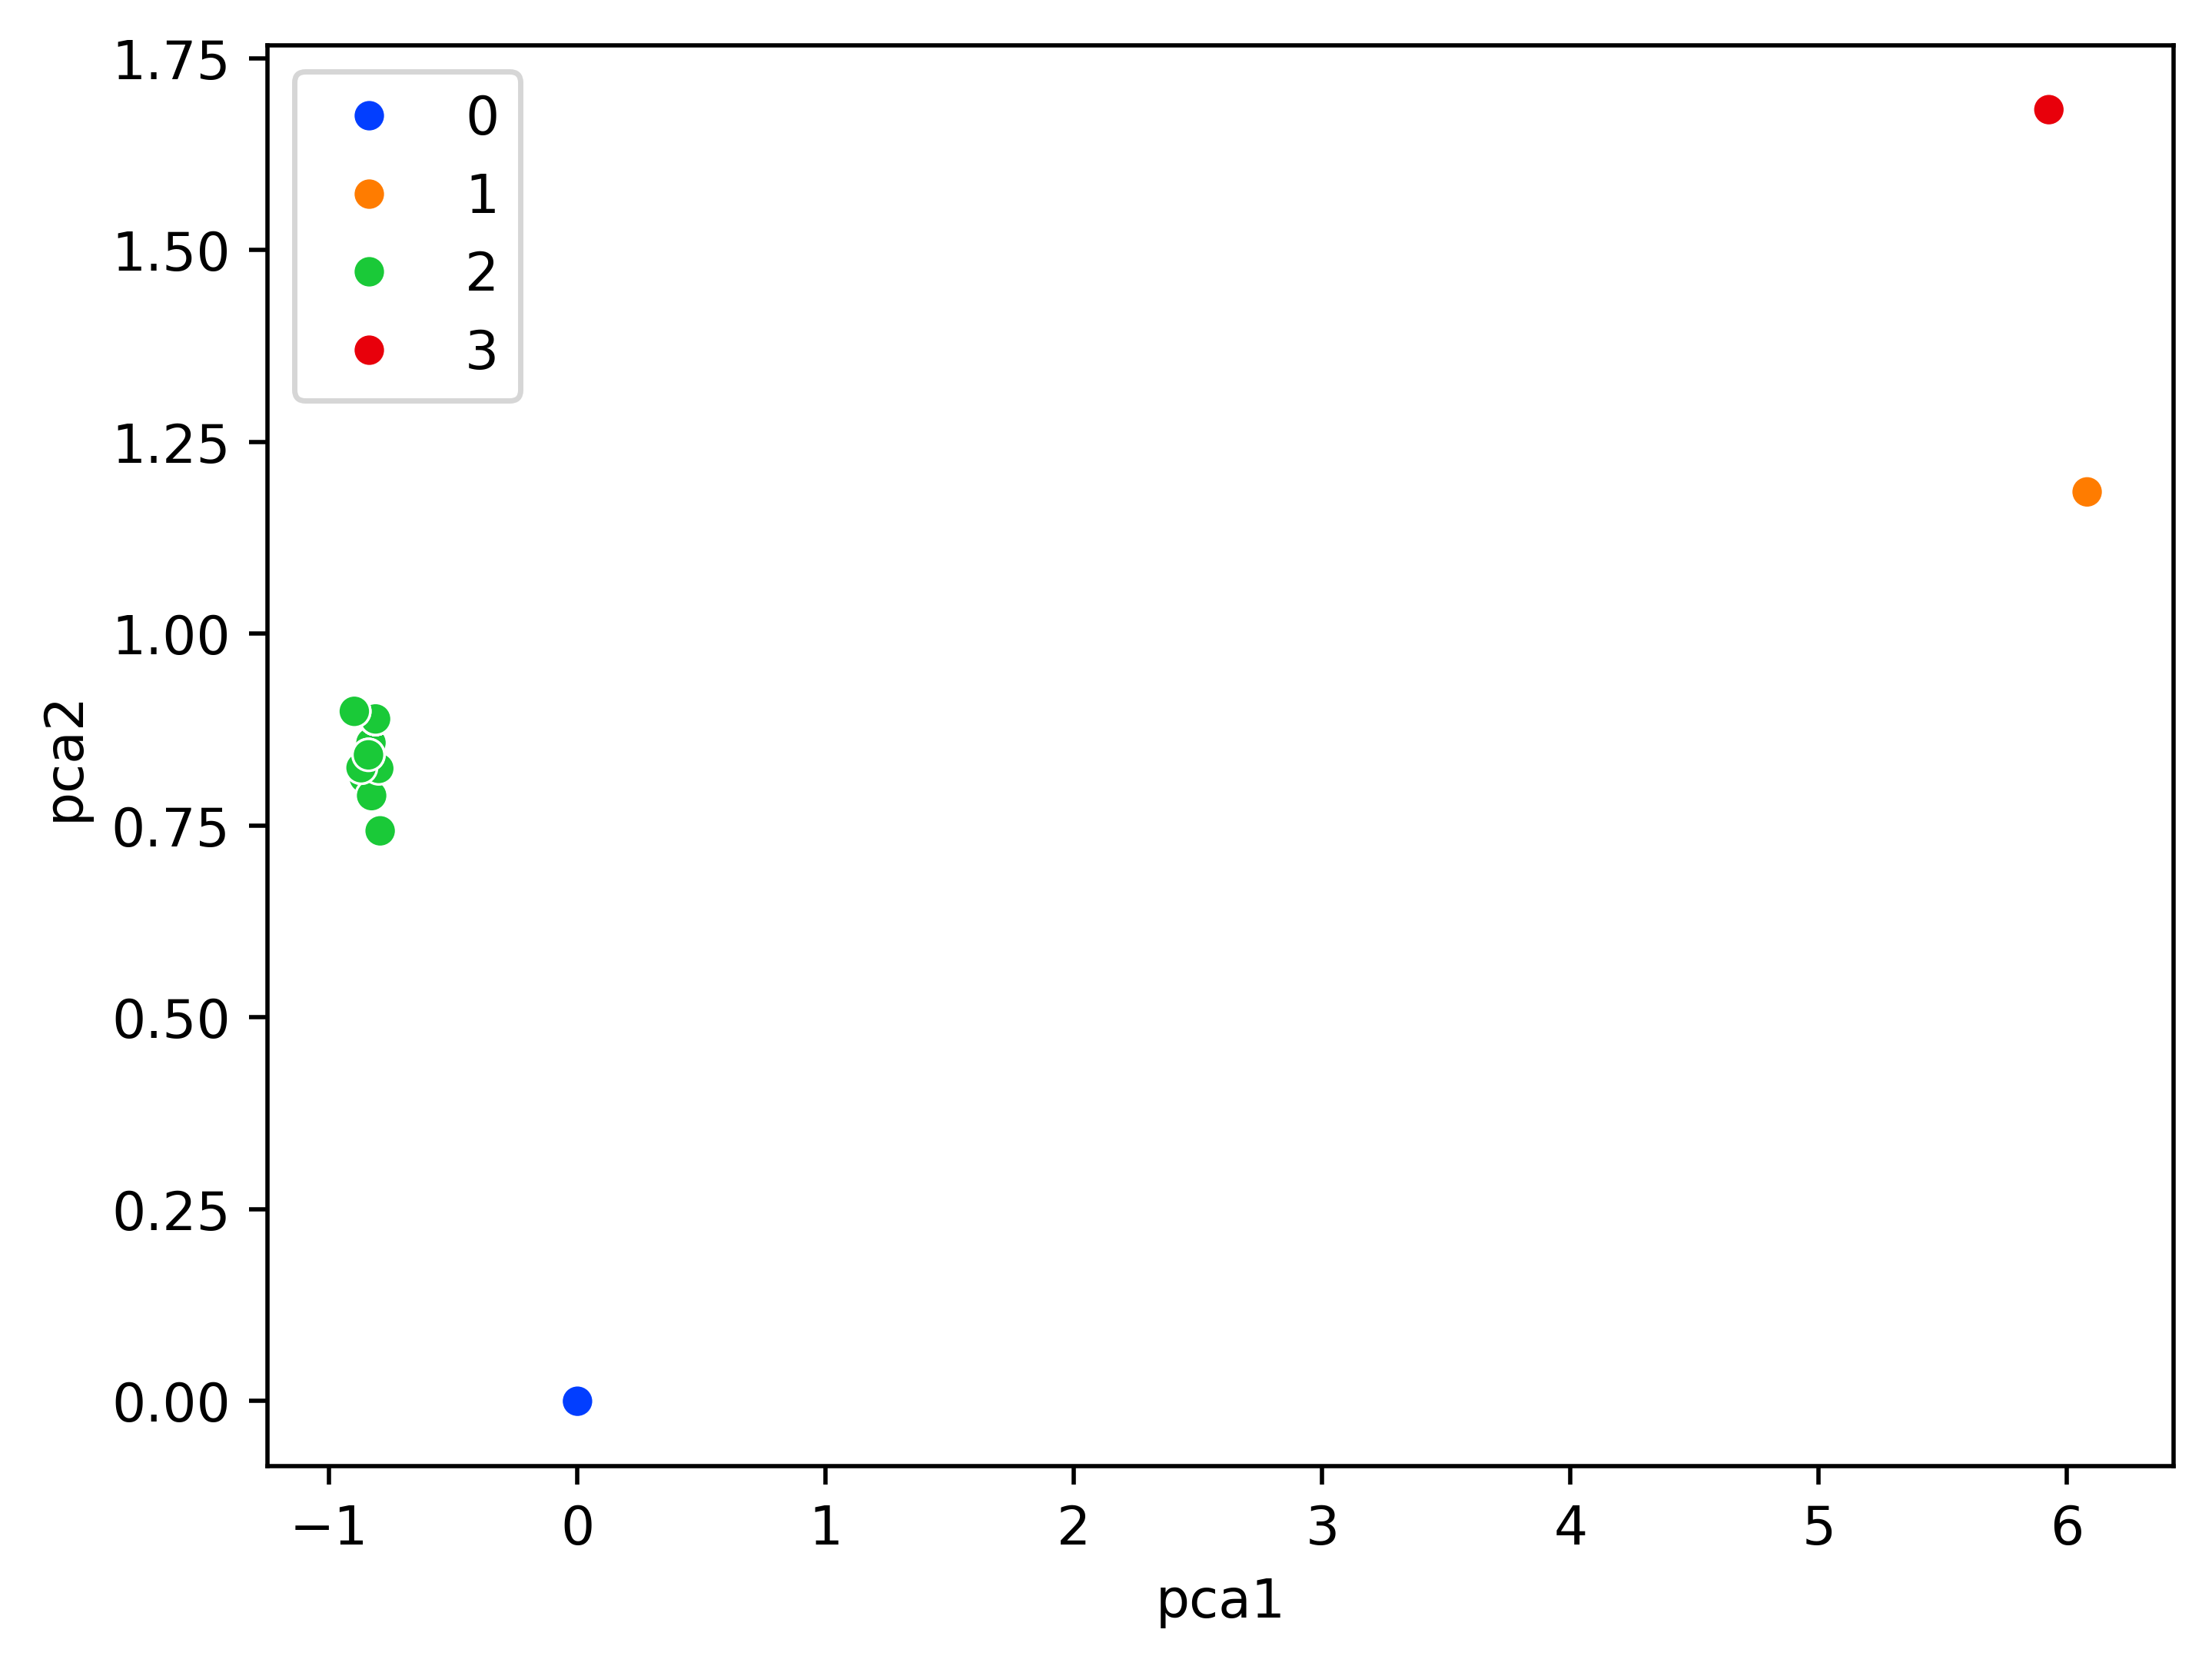

In [ ]:
plt.figure(dpi=400)

sns.scatterplot(
    transformed_embeddings,
    x='pca1',
    y='pca2', 
    hue=cluster_labels,
    palette='bright'
    )

plt.show()

TSNE visualization

In [58]:
tsne = TSNE(n_components=2, perplexity=76)
s = tsne.fit_transform(np.array(embeddings))

In [59]:
tsne_transformed_embeddings = pd.DataFrame(s, columns=['component_1', 'component_2'])

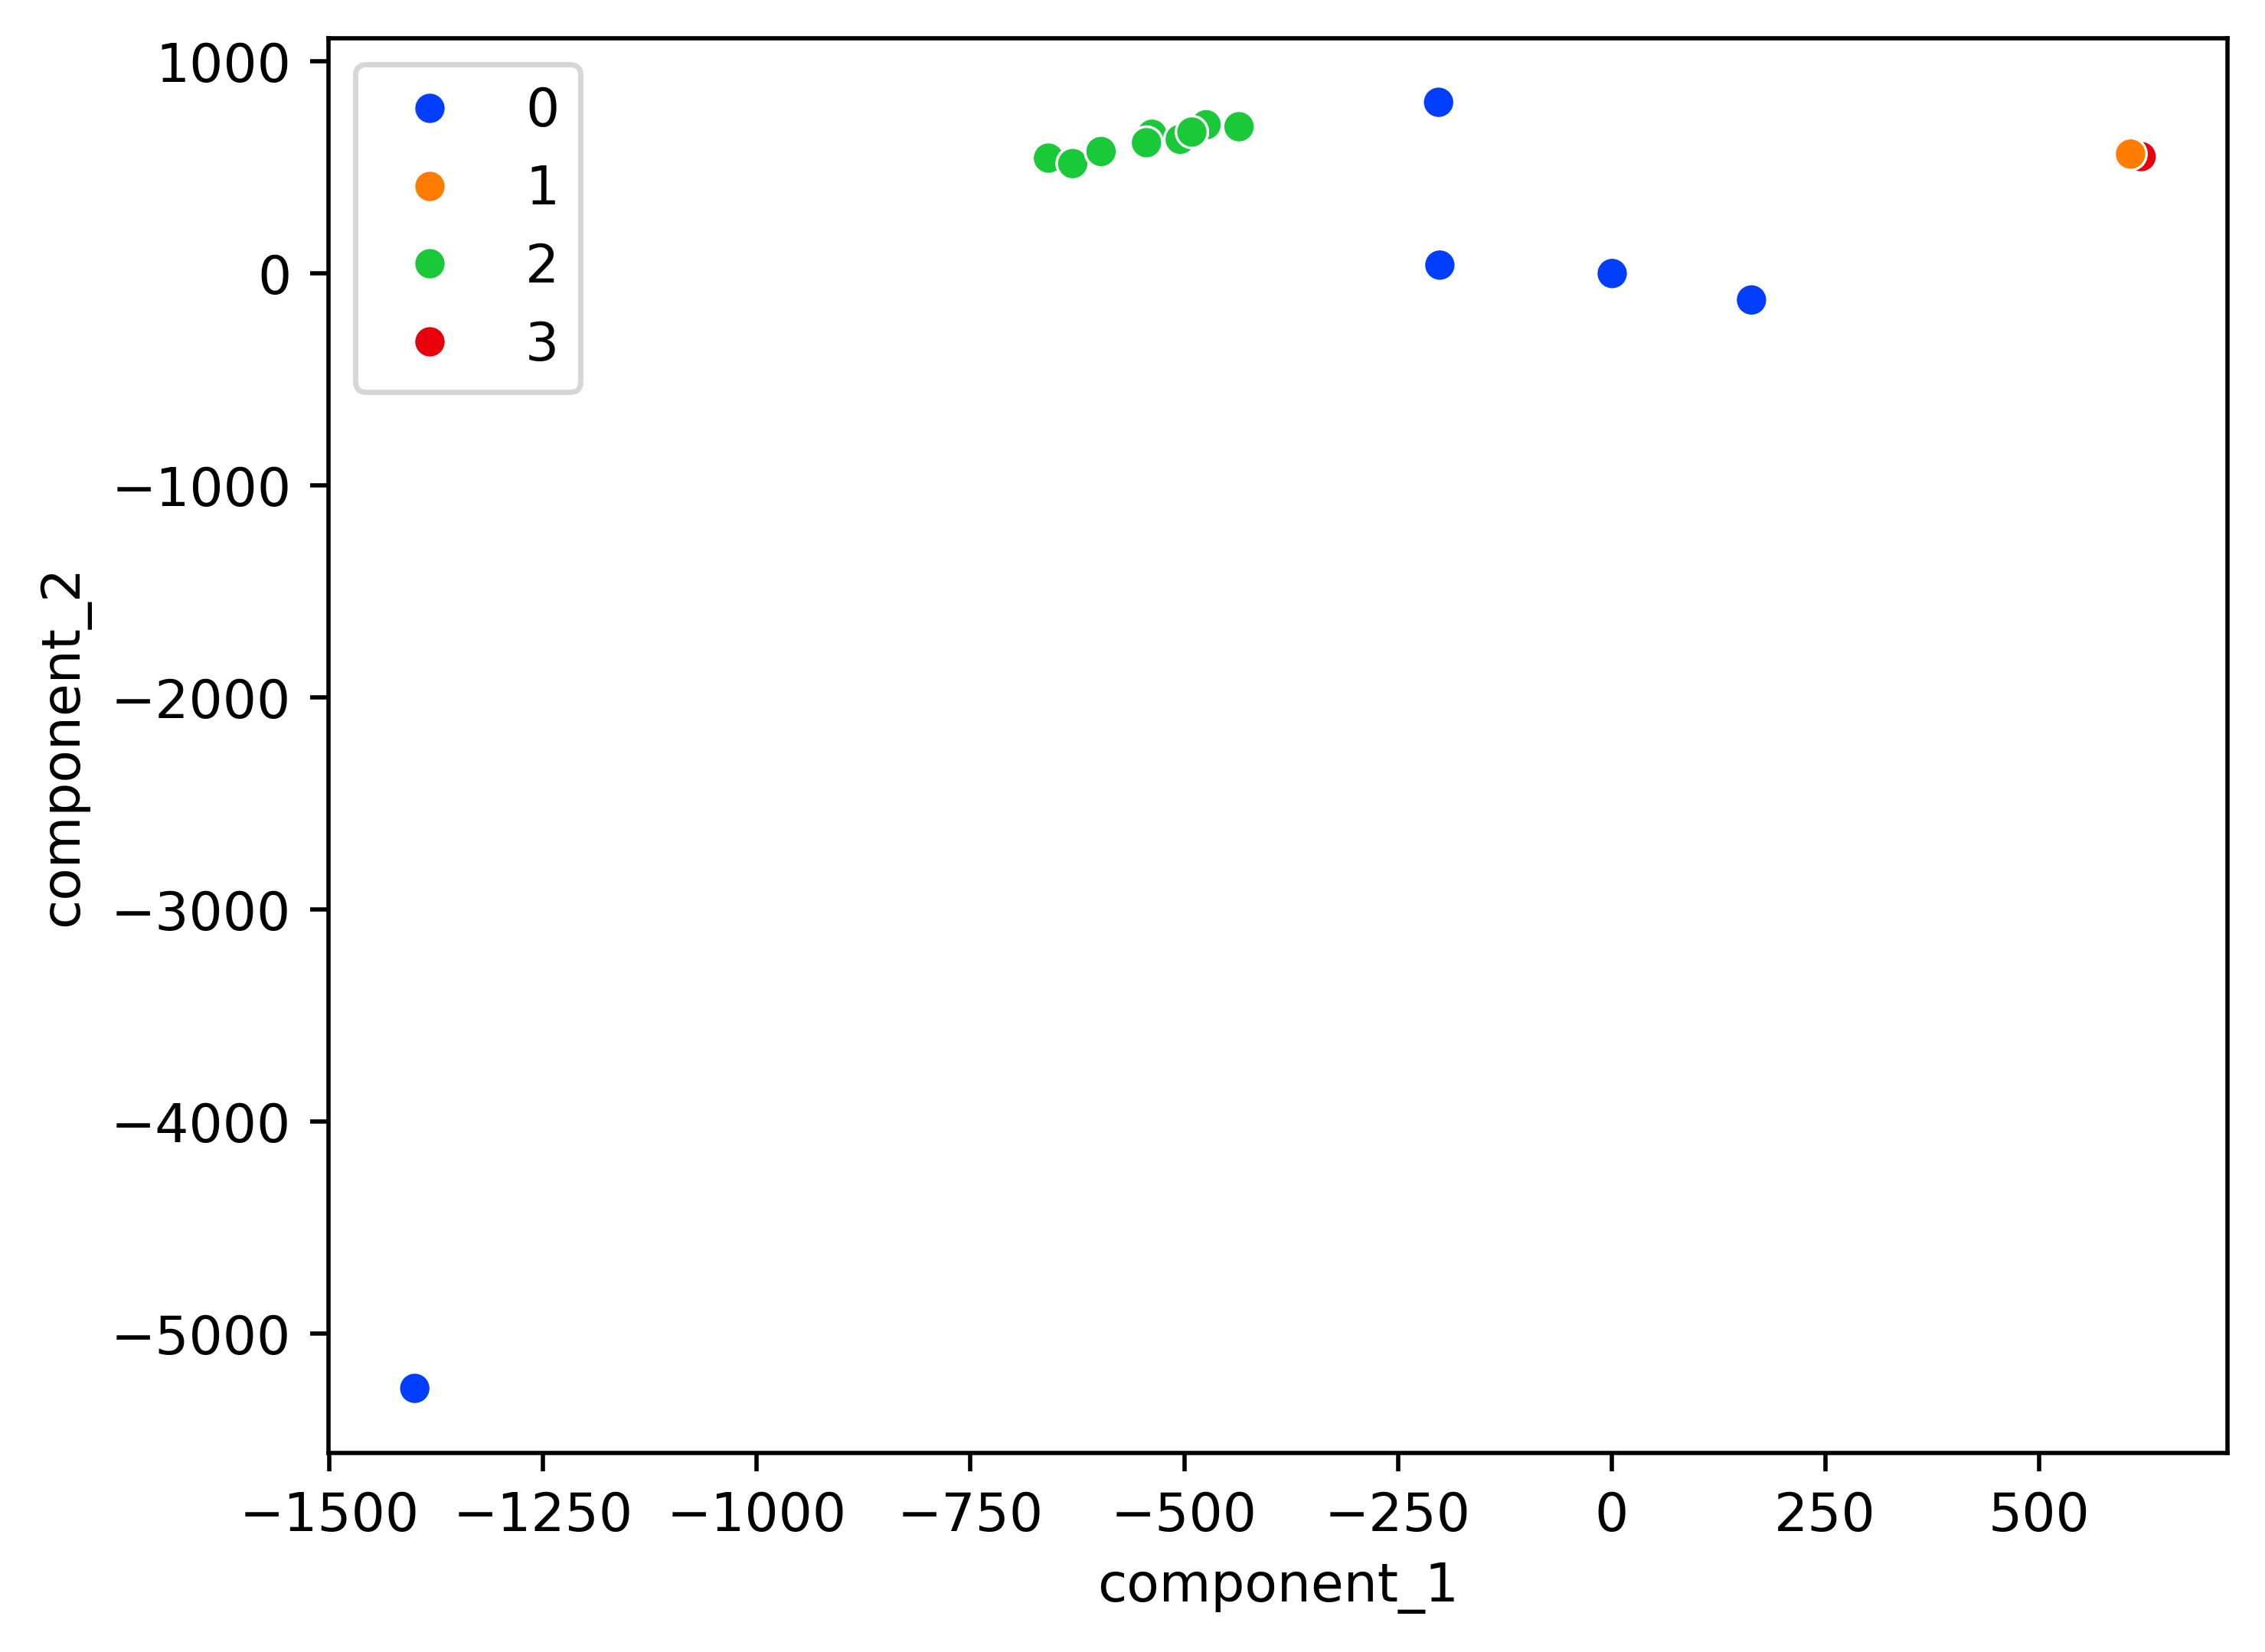

In [ ]:
plt.figure(dpi=400)

sns.scatterplot(
    tsne_transformed_embeddings,
    x='component_1',
    y='component_2',
    hue=cluster_labels,
    palette='bright'
    )

plt.show()